### Import Packages

In [95]:
from __future__ import absolute_import, division, print_function
%load_ext autoreload
%autoreload 2

import numpy as np
from time import gmtime, strftime
import random

# TensorFlow and tf.keras
import tensorflow as tf

import aging as age

print(tf.test.gpu_device_name())

# Define directory with matlab files
# direc = 'D:/MLdata/18-01-09d-Exp/Extract Data/'
# direc  = 'D:/Nicholas_ML/18-01-09d-Exp/Extract Data/'
direc = 'D:/MLdata/'
# Define directory to save model and plots
savedir = 'D:/MLdata/Model/' + strftime("%Y-%m-%d %H-%M", gmtime()) + '/'

random.seed(0)
np.random.seed(0)

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload
/device:GPU:0


### Import Data

A lot of things are hidden behind the scenes in this code.  This allows for compactness within the Jupyter notebook.

In order to properly import the data, there are several options which can be varied.

In [96]:
# Optimized Data Extractor
crop_size = 750
split_size = crop_size // 3
clip_value = 1
image_grid_size = int(crop_size**2 / split_size**2)

file_num = 50

folders, files = age.seq_file_names(direc = direc, 
                                which_samples = (0,), 
                                num_exps = file_num)

skip_exp = ['ML_block1_Exp265.mat', 
            'ML_block1_Exp272.mat',
           'ML_block1_Exp278.mat',
           'ML_block1_Exp386.mat',
           'ML_block1_Exp388.mat',
           'ML_block1_Exp392.mat']

for skip in skip_exp:
    files = list(filter((skip).__ne__, files))

['18-01-09d-Exp']


In [ ]:
length_index, split_images, label_dic = age.data_extractor(files, 
                     folders, 
                     direc = direc, 
                     crop_size = crop_size, 
                     split_size = split_size,
                     clip_value = clip_value,
                     subtract = True, 
                     log_image = True, 
                     younger = 0)

### Troubleshooting

In [ ]:
# age.intensity_plotter(length_index, label_dic, 
#                       split_images, image_grid_size,
#                      normalize_to_1 = True, normalize_all = True, 
#                       log_plot = False)

In [ ]:
# age.time_plotter(length_index, files, label_dic, 
#                  split_images, image_grid_size, full = False)
# # age.difference(Fs_label, Fn_label, T_label, split_images, length_index, files, image_grid_size)

### Assemble Data

In [ ]:
train_data, train_labels, train_meta, test_data, test_labels, test_meta = \
        age.withhold_sqr(
            split_images = split_images, 
            ML_labels = ['T'],
            label_dic = label_dic,
            image_grid_size = image_grid_size, 
            log_time = True,
            cols = int(np.ceil(.2*image_grid_size)))

# train_data, train_labels, train_meta, test_data, test_labels, test_meta = \
#         age.withold_exp(
#             split_images = split_images, 
#             ML_labels = ['T'],
#             label_dic = label_dic,
#             log_time = True)

# train_data, train_labels, test_data, test_labels = \
# age.younger(train_data, train_labels, test_data, test_labels, time_cut = 5)

min_val = np.min([np.min(train_data), np.min(test_data)])

#Final Renormilization of Images to be between 0 and 1
train_data = (train_data - min_val)/(1 - min_val)
test_data = (test_data - min_val)/(1 - min_val)

### Build CNN

In [43]:
image_size = train_data.shape[1]
    
# Create the base model
# https://keras.io/applications/#inceptionv3
base_model = tf.keras.applications.inception_v3.InceptionV3(
                include_top=False, 
                weights='imagenet', 
                input_shape=(image_size,image_size,3))

base_model.trainable = False
    
incep_model = tf.keras.Sequential([
    base_model,
    tf.keras.layers.Conv2D(32, (3, 3)),
    tf.keras.layers.LeakyReLU(alpha=0.5),
    tf.keras.layers.Dropout(rate = 0.3),
    tf.keras.layers.Flatten(),
    tf.keras.layers.Dense(64),
    tf.keras.layers.LeakyReLU(alpha=0.5),
    tf.keras.layers.Dropout(rate = 0.3),
    tf.keras.layers.Dense(1),
    tf.keras.layers.LeakyReLU(alpha=0.5)
    ])

#custom_model = tf.keras.Sequential([
#        tf.keras.layers.Conv2D(8, kernel_size=(2, 2),
#                       input_shape=(image_size, image_size, 1)),
#        tf.keras.layers.LeakyReLU(alpha=0.5),
#        tf.keras.layers.Dropout(rate = 0.3),
#        tf.keras.layers.Conv2D(16, (3, 3)),
#        tf.keras.layers.LeakyReLU(alpha=0.5),
#        tf.keras.layers.Dropout(rate = 0.3),
#        tf.keras.layers.Flatten(),
#        tf.keras.layers.Dense(32),
#        tf.keras.layers.LeakyReLU(alpha=0.5),
#        tf.keras.layers.Dropout(rate = 0.3),
#        tf.keras.layers.Dense(1),
#        tf.keras.layers.LeakyReLU(alpha=0.5)

Instructions for updating:
Colocations handled automatically by placer.
Instructions for updating:
Please use `rate` instead of `keep_prob`. Rate should be set to `rate = 1 - keep_prob`.


### Train CNN

In [59]:
model, history = age.inception_train(
                    train_data, 
                    train_labels, 
                    test_data, 
                    test_labels,
                    savedir, 
                    incep_model,
                    epochs = 10,
                    patience = 20)

# model, history = age.aion(train_data, train_labels, test_data, test_labels,
#                     savedir, full_model)

Train on 469 samples, validate on 134 samples
Epoch 1/10
469/469 [==============================] - 5s 11ms/sample - loss: 0.1081 - mean_absolute_error: 1.0373 - acc: 0.0000e+00 - val_loss: 0.2169 - val_mean_absolute_error: 1.4238 - val_acc: 0.0000e+00
Epoch 2/10
469/469 [==============================] - 2s 4ms/sample - loss: 0.0968 - mean_absolute_error: 1.0102 - acc: 0.0000e+00 - val_loss: 0.2150 - val_mean_absolute_error: 1.4162 - val_acc: 0.0000e+00
Epoch 3/10
469/469 [==============================] - 2s 4ms/sample - loss: 0.0965 - mean_absolute_error: 1.0414 - acc: 0.0000e+00 - val_loss: 0.2110 - val_mean_absolute_error: 1.4131 - val_acc: 0.0000e+00
Epoch 4/10
469/469 [==============================] - 2s 4ms/sample - loss: 0.0807 - mean_absolute_error: 0.9411 - acc: 0.0000e+00 - val_loss: 0.3354 - val_mean_absolute_error: 1.6857 - val_acc: 0.0000e+00
Epoch 5/10
469/469 [==============================] - 2s 4ms/sample - loss: 0.0841 - mean_absolute_error: 0.9265 - acc: 0.0000e+0

In [60]:
test_predic = model.predict(np.tile(
    test_data.reshape(test_data.shape[0], 
    test_data.shape[1], 
    test_data.shape[2], 
    1), 
        3))
train_predic = model.predict(np.tile(train_data.reshape(
    train_data.shape[0], 
    train_data.shape[1],  
    train_data.shape[2], 
    1),
        3))

### Examine Results

In [61]:
# model = load_model('my_model.h5')

In [62]:
# import matplotlib.pyplot as plt

# print(test_meta['Exp'][:62])

# for i in range(62):
#     plt.figure()
#     plt.title('Fs: ' + str(np.round(test_meta['Fs'][i],2)) +
#              ' T: ' + str(np.round(test_labels[i][0],2)) +
#              ' Exp: ' + str(test_meta['Exp'][i]))
#     plt.imshow(test_data[i])
#     plt.show()

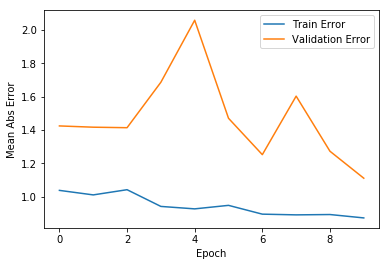

In [63]:
age.hist_plotter(history, savedir + "Incep_history")

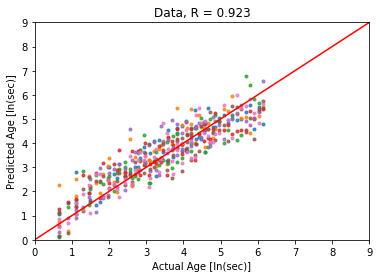

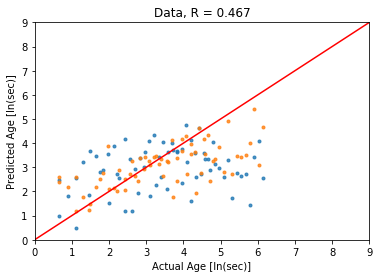

In [84]:
train_times = train_labels.reshape(-1, int(np.floor(.8*image_grid_size)))
train_pred_times = train_predic.reshape(-1, int(np.floor(.8*image_grid_size)))

# train_shear = train_labels[:,1]
# train_pred_shear = train_predic[:,1]

test_times = test_labels.reshape(-1, int(np.ceil(.2*image_grid_size)))
test_pred_times = test_predic.reshape(-1, int(np.ceil(.2*image_grid_size)))

# test_shear = test_labels[:,1]
# test_pred_shear = test_predic[:,1]

age.data_plotter(train_times, train_pred_times, 
                 savedir + "Incep_Age_train" ,
                 lim = 9,
                 marker = ".", alpha = .8)

age.data_plotter(test_times, test_pred_times, 
                 savedir + "Incep_Age_test" ,
                 lim = 9,
                 marker = ".", alpha = .8)

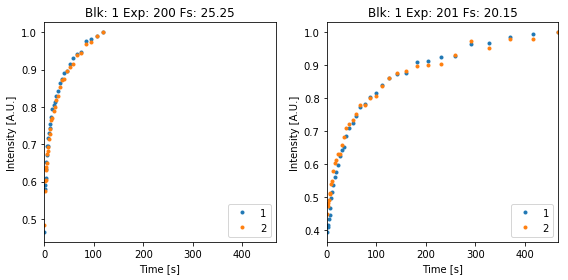

In [94]:
test_meta['T'] = np.exp(test_labels.flatten())
age.intensity_plotter(length_index, test_meta, 
                      test_data, 2,
                     normalize_to_1 = True, normalize_all = True, 
                      log_plot = False)